In [ ]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../../../") )
sys.path.append("../../../")
sys.path.append("../")
from hippylib import *
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff_fwd import TimeDependentAD, SpaceTimePointwiseStateObservation
from fourier import * 
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [9]:
def advected_centers(t_path, x0, wind_velocity, substeps=10):
    """
    Compute drifting centers c(t) by integrating c'(t)=v(c(t)).
    Uses simple forward Euler with `substeps` per interval.
    """
    c = np.array(x0, dtype=float)
    centers = [c.copy()]
    for i in range(1, len(t_path)):
        t0, t1 = t_path[i-1], t_path[i]
        h = (t1 - t0) / substeps
        for _ in range(substeps):
            v = np.array(wind_velocity(c), dtype=float)  # may need minor tweak, see note below
            c = c + h * v
            c[0] = np.clip(c[0], 0.0, 1.0)
            c[1] = np.clip(c[1], 0.0, 1.0)
        centers.append(c.copy())
    return np.array(centers)


In [10]:
def v_boundary(x, on_boundary):
    return on_boundary

def q_boundary(x, on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS

def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh, 'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    mixed_element = ufl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
    XW = dl.FunctionSpace(mesh, mixed_element)

    Re = dl.Constant(100.0)

    g = dl.Expression(('4.0*x[1]*(1.0-x[1])', '0.0'), degree=2)
    
    bc1 = dl.DirichletBC(XW.sub(0), g, "near(x[0], 0.0)")
    bc2 = dl.DirichletBC(XW.sub(0), dl.Constant((0.0, 0.0)), "near(x[1], 0.0) || near(x[1], 1.0)")
    bc3 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    
    bcs = [bc1, bc2, bc3]

    vq = dl.Function(XW)
    (v, q) = ufl.split(vq)
    (v_test, q_test) = dl.TestFunctions(XW)

    def strain(v):
        return ufl.sym(ufl.grad(v))

    F = ( (2./Re)*ufl.inner(strain(v), strain(v_test)) 
          + ufl.inner(ufl.nabla_grad(v)*v, v_test)
          - (q * ufl.div(v_test)) 
          + (ufl.div(v) * q_test) ) * ufl.dx

    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})

    vh = dl.project(v, Xh)
    qh = dl.project(q, Wh)
    
    plt.figure(figsize=(15, 5))
    
    mesh_coarse =  dl.UnitSquareMesh(60, 60)
    vh_coarse = dl.interpolate(vh, dl.VectorFunctionSpace(mesh_coarse, "CG", 1))
    
    nb.plot(vh_coarse, subplot_loc=121, mytitle="Velocity (Parabolic)")
    nb.plot(qh, subplot_loc=122, mytitle="Pressure")
    plt.show()

    return vh


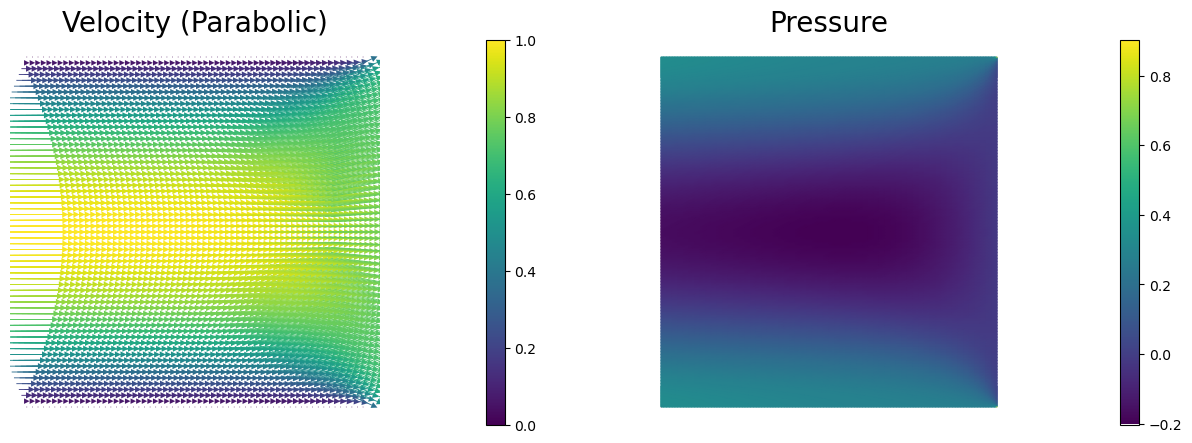

Number of dofs: 21103


In [11]:
nx, ny = 60, 120
mesh = dl.UnitSquareMesh(nx, ny)

for _ in range(2):  
    markers = dl.MeshFunction("bool", mesh, mesh.topology().dim())
    markers.set_all(False)

    for cell in dl.cells(mesh):
        y = cell.midpoint().y()
        if y < 0.06 or y > 0.94:     
            markers[cell] = True

    mesh = dl.refine(mesh, markers)

wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print("Number of dofs: {0}".format(Vh.dim()))

In [12]:
targets = np.loadtxt('targets.txt')
targets_all = targets
print("Number of observation points:", targets.shape[0])

Number of observation points: 80


Number of observation points: 30


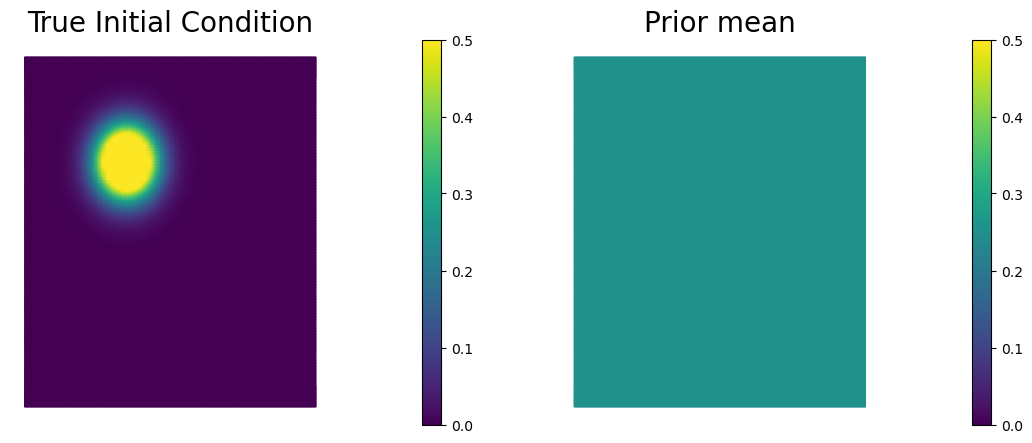

In [13]:
ic_expr = dl.Expression(
    'std::min(0.5, std::exp(-100*(std::pow(x[0]-0.35,2) + std::pow(x[1]-0.7,2))))',
    element=Vh.ufl_element()
)
true_initial_condition = dl.interpolate(ic_expr, Vh).vector()

gamma = 1.
delta = 8.
prior = BiLaplacianPrior(Vh, gamma, delta, robin_bc=True)
prior.mean = dl.interpolate(dl.Constant(0.25), Vh).vector()

t_init = 0.
t_final = 4.
t_1 = 1.
dt = .1
observation_dt = .2

simulation_times = np.arange(t_init, t_final + .5*dt, dt)
observation_times = np.arange(t_1, t_final + .5*dt, observation_dt)

Ty = (t_1, t_final)
Nf = 3
omegas = fourier_frequencies(Ty, Nf)

xbar = np.array([0.35, 0.70], dtype=float)

coeffs = np.array([
    [0.10, 0.00, 0.00, 0.08],
    [0.05, 0.03, 0.02, 0.00],
    [0.02, 0.01, 0.00, 0.02],
], dtype=float)

M = 30
t_path = np.linspace(t_1, t_final, M)

centers = advected_centers(t_path, xbar, wind_velocity, substeps=20)

targets = np.array([
    centers[i] + (fourier_path(t_path[i], np.array([0.0, 0.0]), coeffs, omegas) )
    for i in range(M)
])

# keep inside the unit square
targets[:,0] = np.clip(targets[:,0], 0.0, 1.0)
targets[:,1] = np.clip(targets[:,1], 0.0, 1.0)


print("Number of observation points:", targets.shape[0])

misfit = SpaceTimePointwiseStateObservation(Vh, observation_times, targets)


problem = TimeDependentAD(mesh, [Vh, Vh, Vh], prior, misfit, simulation_times, wind_velocity, True)

objs = [
    dl.Function(Vh, true_initial_condition),
    dl.Function(Vh, prior.mean)
]
mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

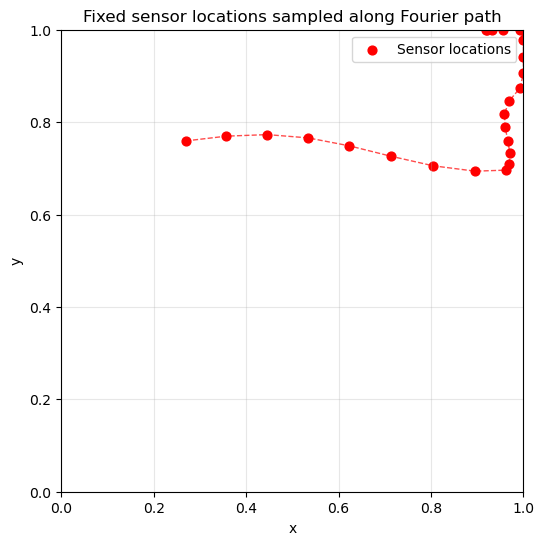

In [14]:
plt.figure(figsize=(6, 6))

plt.scatter(targets[:, 0], targets[:, 1],
            c='red', s=40, label='Sensor locations')

plt.plot(targets[:, 0], targets[:, 1],
         'r--', linewidth=1, alpha=0.7)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.gca().set_aspect('equal', 'box')
plt.grid(True, alpha=0.3)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fixed sensor locations sampled along Fourier path')
plt.legend()
plt.show()


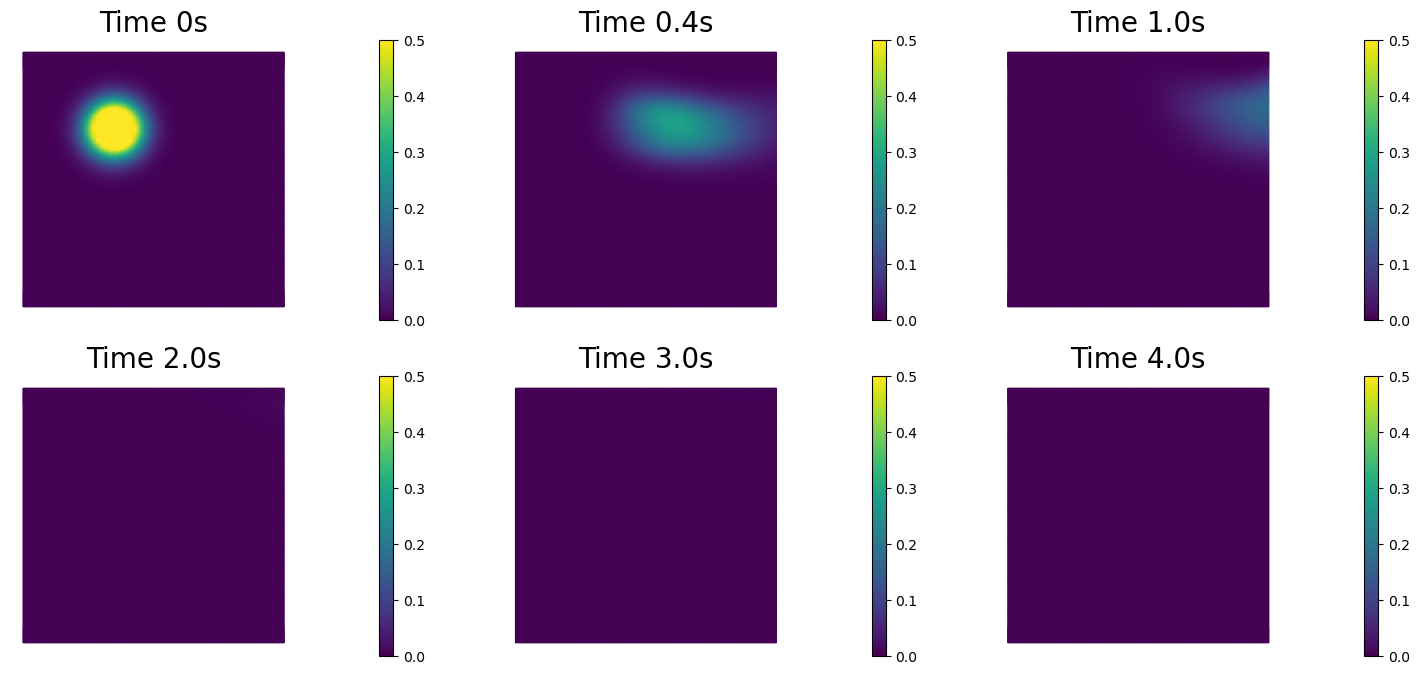

In [15]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev * noise_std_dev
nb.show_solution(Vh, true_initial_condition, utrue, "Solution (True + Noisy Observations)")


(yy, H xx) - (xx, H yy) =  -2.318638802550834e-15


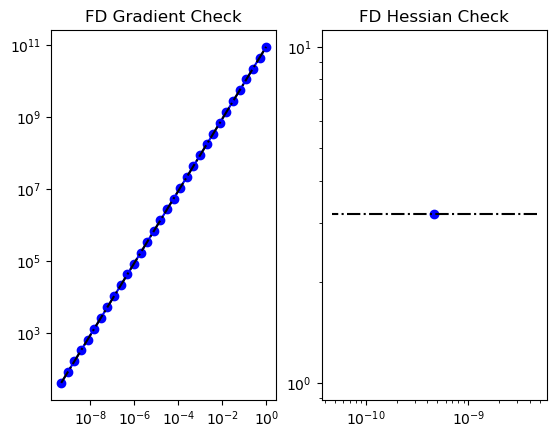

In [16]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, is_quadratic=True)

In [17]:
[u, m, p] = problem.generate_vector()

# (Optional) make it explicit like Code A usually implies:
# m.zero()

problem.solveFwd(u, [u, m, p])
problem.solveAdj(p, [u, m, p])

mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u, m, p], mg)

print("(g,g) = ", grad_norm)


(g,g) =  6172352465258294.0


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


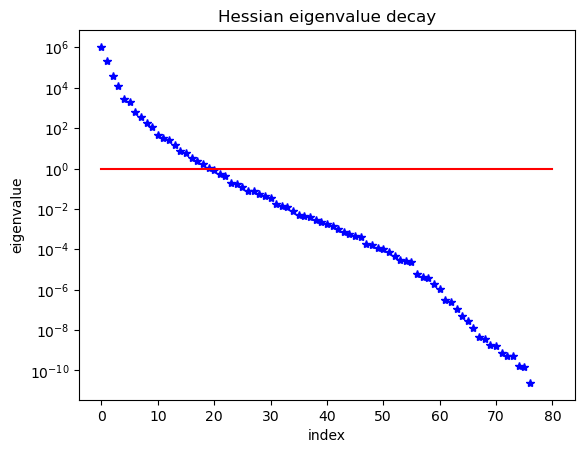

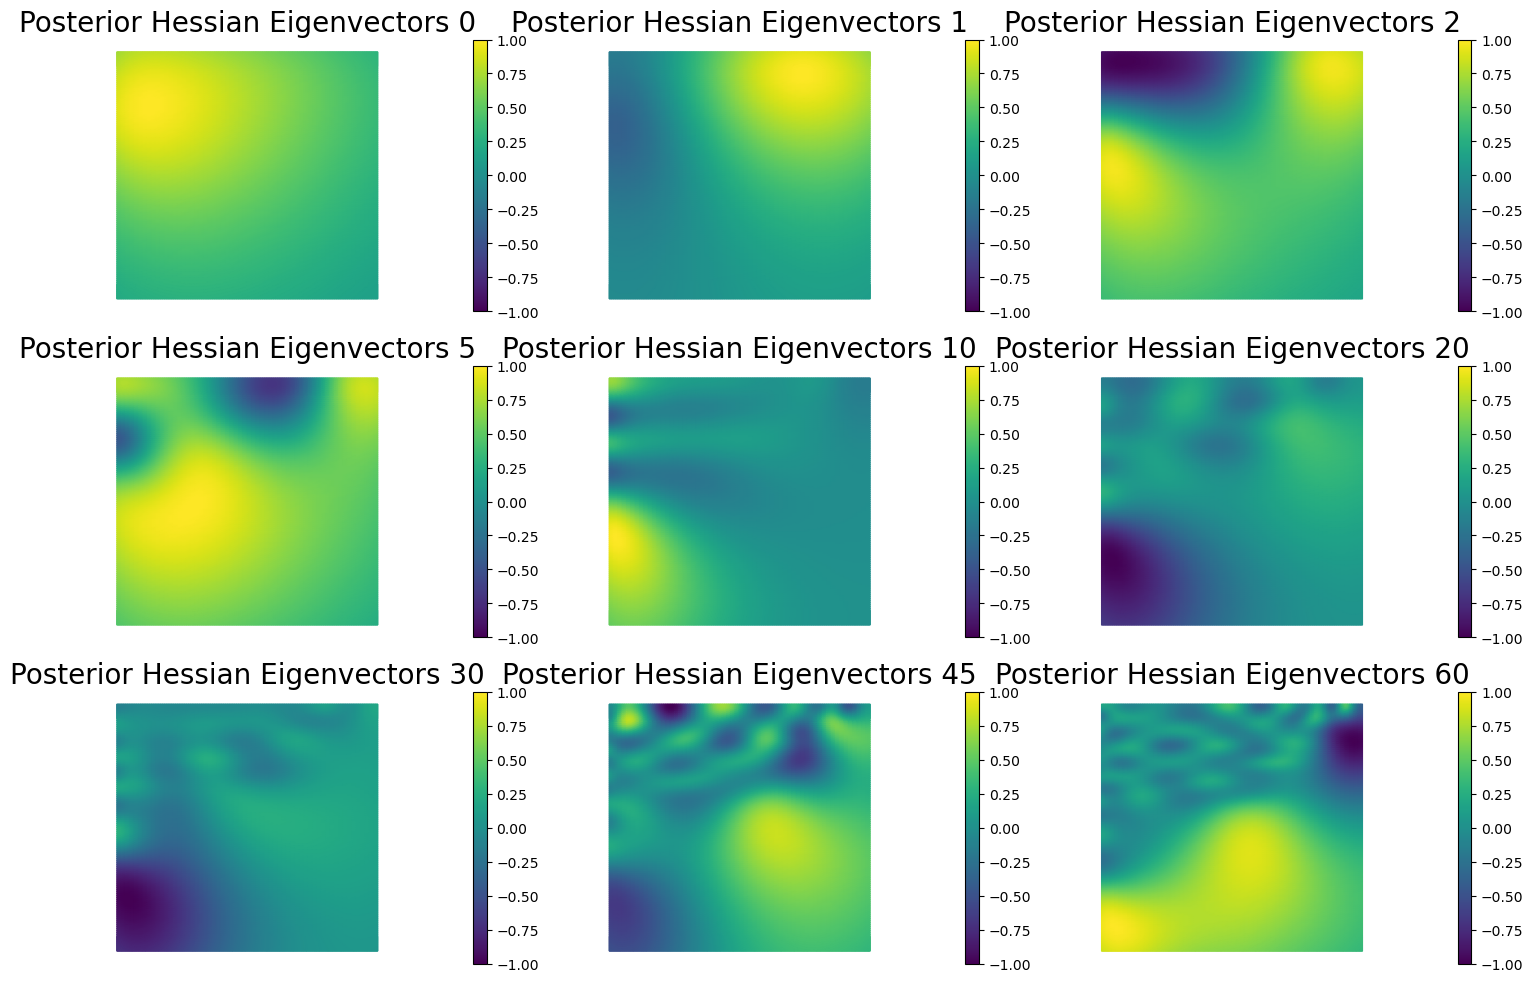

In [18]:
u_lin = problem.generate_vector(STATE)
x_lin = [u_lin, m, None]

problem.solveFwd(x_lin[STATE], x_lin)

H = ReducedHessian(problem, misfit_only=True)

k = 80
p = 20
print("Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}."
      .format(k, p))

Omega = MultiVector(x_lin[PARAMETER], k + p)
parRandom.normal(1.0, Omega)

lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)

posterior = GaussianLRPosterior(prior, lmbda, V)

plt.figure()
plt.plot(range(k), lmbda, 'b*', range(k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.title('Hessian eigenvalue decay')
plt.show()

nb.plot_eigenvectors(
    Vh, V,
    mytitle="Posterior Hessian Eigenvectors",
    which=[0, 1, 2, 5, 10, 20, 30, 45, 60]
)
plt.show()


 Iterartion :  0  (B r, r) =  106724.26116341537
 Iteration :  1  (B r, r) =  0.026051153277553373
 Iteration :  2  (B r, r) =  2.6172504234474227e-07
 Iteration :  3  (B r, r) =  2.2661977948072866e-12
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  1.5053895824029362e-06
Total cost 320.745; Reg Cost 75.6929; Misfit 245.052


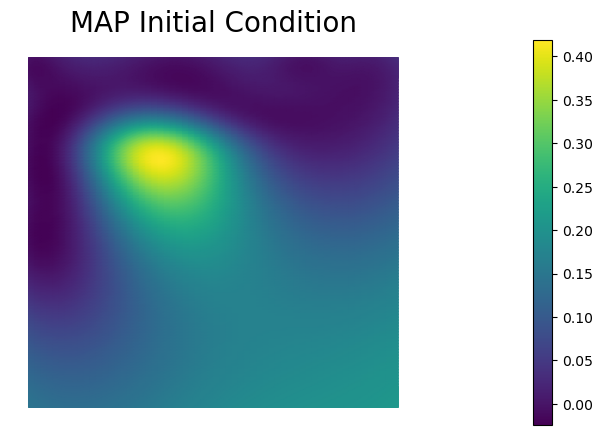

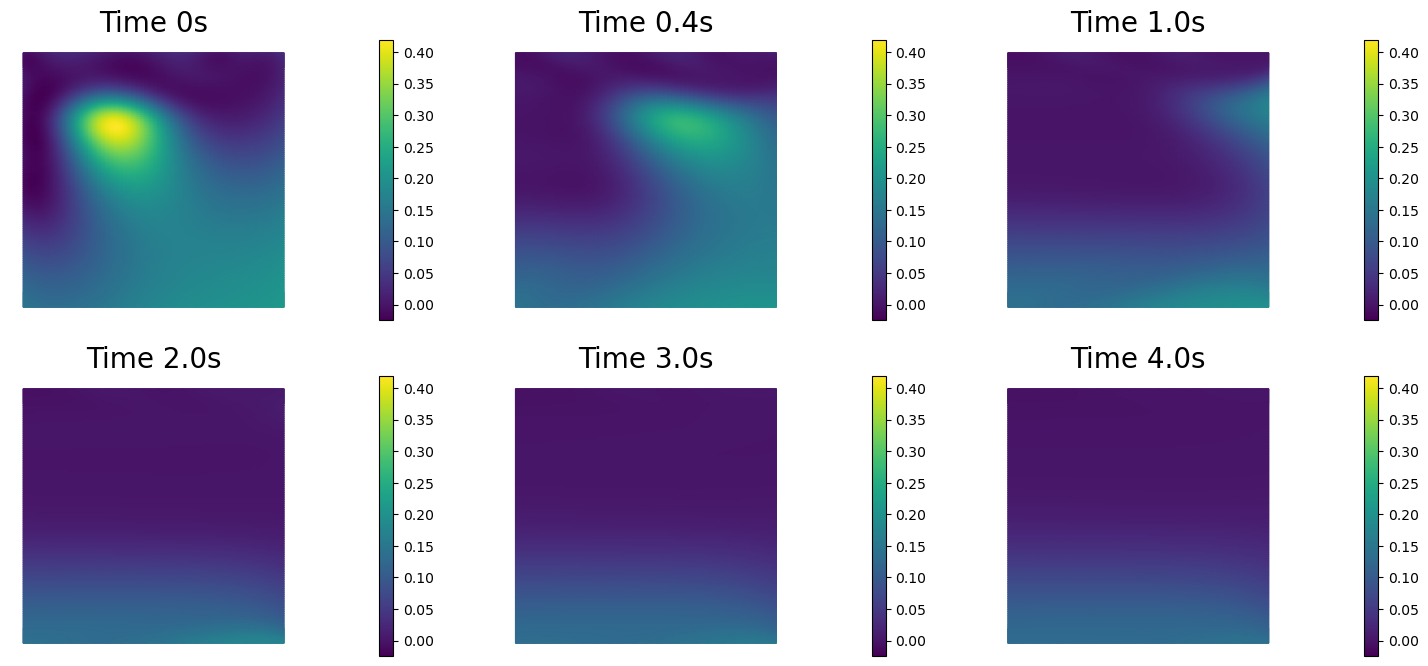

In [19]:
H.misfit_only = False

solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner(posterior.Hlr)

solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

solver.solve(m, -mg)
try:
    u
    p
except NameError:
    u = problem.generate_vector(STATE)
    p = problem.generate_vector(ADJOINT)

problem.solveFwd(u, [u, m, p])
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

posterior.mean = m

plt.figure(figsize=(7.5, 5))
nb.plot(dl.Function(Vh, m), mytitle="MAP Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution at MAP")
plt.show()


Posterior trace 0.00344302; Prior trace 0.010428; Correction trace 0.006985


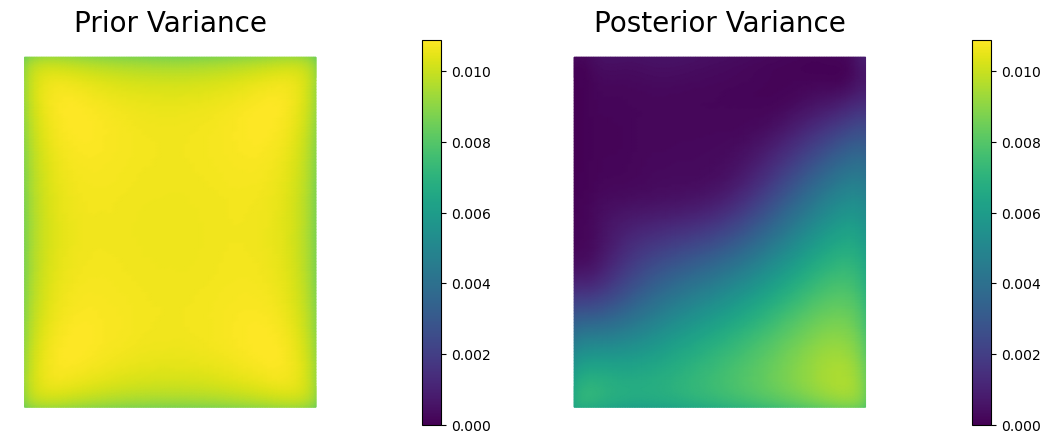

In [20]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()


In [21]:
def compute_EIG_for_c(c_mask, r=20, oversampling=10):
    """
    Computes EIG(c) = sum_{i=1}^r log(1 + lambda_i)

    Control c enters ONLY through B(c), implemented by selecting targets.
    """

    # ----------------------------
    # Build B(c) via target selection
    # ----------------------------
    targets_c = targets_all[c_mask]

    misfit_c = SpaceTimePointwiseStateObservation(
        Vh, observation_times, targets_c
    )

    # ----------------------------
    # IMPORTANT FIX:
    # ReducedHessian requires noise_variance != None
    # ----------------------------
    rel_noise = 0.01
    misfit_c.noise_variance = rel_noise ** 2

    # ----------------------------
    # Build inverse problem (unchanged)
    # ----------------------------
    problem_c = TimeDependentAD(
        mesh, [Vh, Vh, Vh],
        prior, misfit_c,
        simulation_times,
        wind_velocity,
        True
    )

    # ----------------------------
    # Reduced Hessian (misfit only)
    # ----------------------------
    H = ReducedHessian(problem_c, misfit_only=True)

    k = r
    p = oversampling

    # Randomized eigensolver setup
    m_template = problem_c.generate_vector(PARAMETER)
    Omega = MultiVector(m_template, k + p)
    parRandom.normal(1.0, Omega)

    # Generalized eigenpairs
    lmbda, V = singlePassG(
        H, prior.R, prior.Rsolver, Omega, k
    )

    # ----------------------------
    # Expected Information Gain
    # ----------------------------
    EIG = float(np.sum(np.log(1.0 + np.array(lmbda))))

    return EIG, lmbda, V


In [22]:
# =========================
# EIG evaluation for a test control c
# =========================

# Example control c: activate the first 30 sensors
N = targets_all.shape[0]
c_mask = np.zeros(N, dtype=bool)
c_mask[:30] = True

EIG_value, lmbda, V = compute_EIG_for_c(c_mask, r=20, oversampling=10)
print("EIG(c) =", EIG_value)


EIG(c) = 32.390050930981126


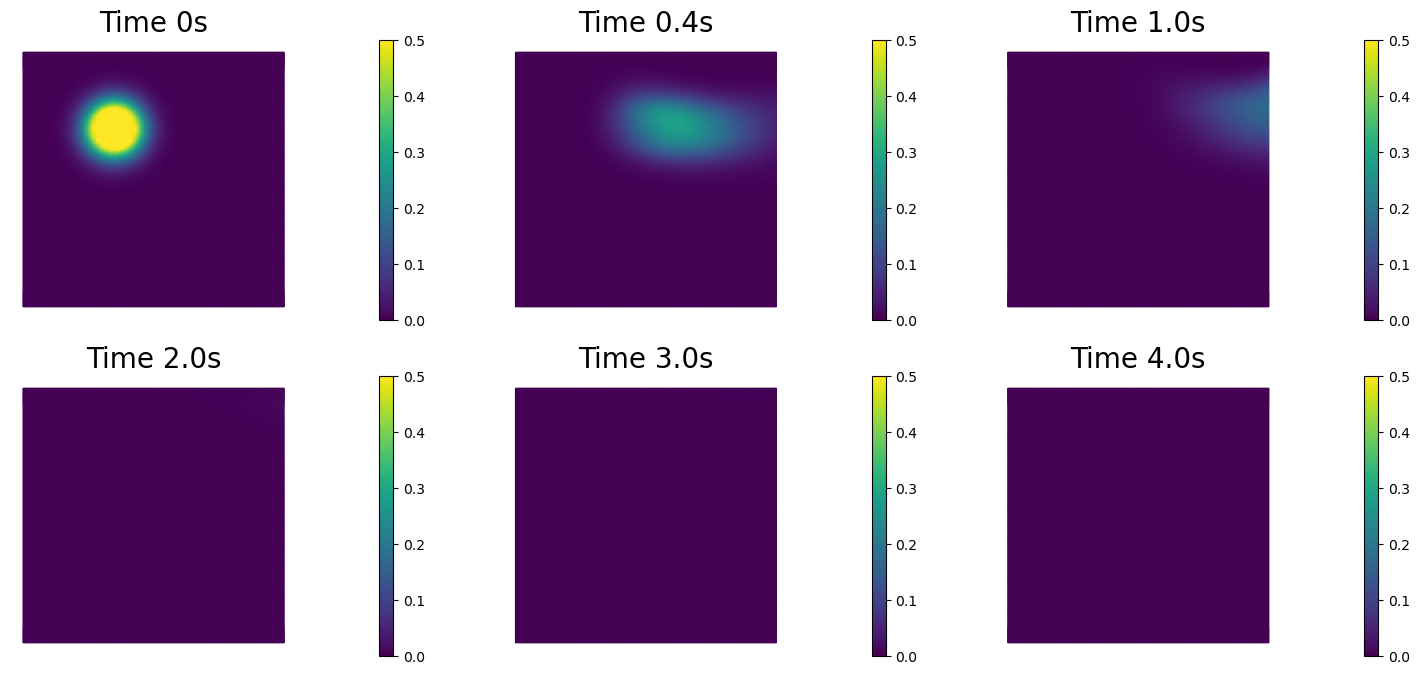

In [23]:
rel_noise = 0.01
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x)
misfit.observe(x, misfit.d)
MAX = misfit.d.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev,misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

nb.show_solution(Vh, true_initial_condition, utrue, "Solution")

(yy, H xx) - (xx, H yy) =  -6.183304721295791e-14


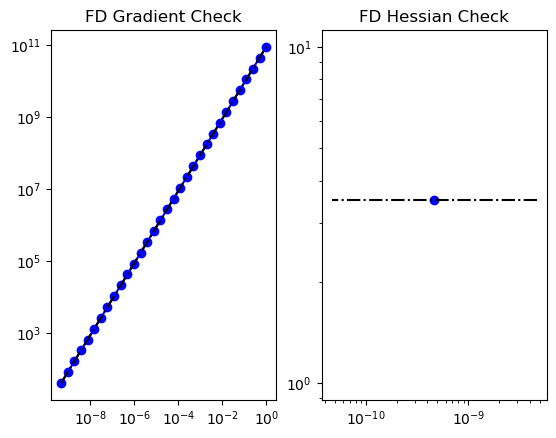

In [24]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, is_quadratic=True)

In [25]:
[u,m,p] = problem.generate_vector()
problem.solveFwd(u, [u,m,p])
problem.solveAdj(p, [u,m,p])
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,m,p], mg)

print( "(g,g) = ", grad_norm)

(g,g) =  6279239575630730.0


Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


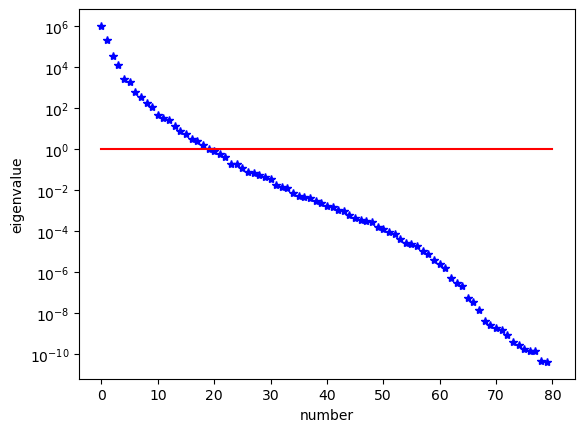

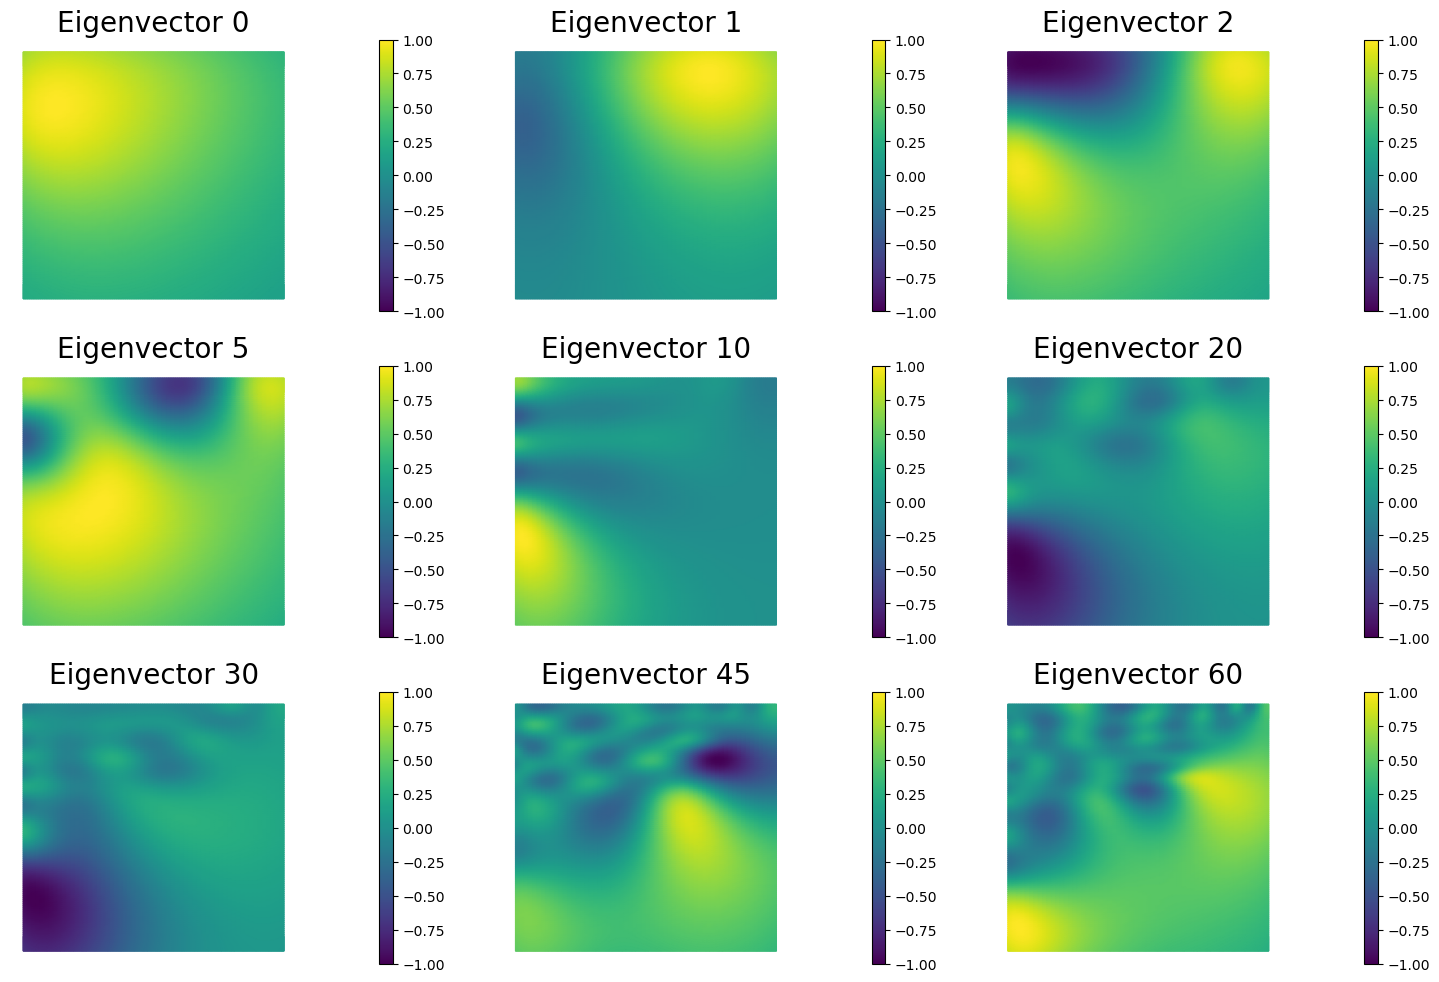

In [26]:
H = ReducedHessian(problem, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

 Iterartion :  0  (B r, r) =  13574165497.288713
 Iteration :  1  (B r, r) =  476889702.74938166
 Iteration :  2  (B r, r) =  2503702662.6663847
 Iteration :  3  (B r, r) =  190353205.56697345
 Iteration :  4  (B r, r) =  241011587.0801236
 Iteration :  5  (B r, r) =  3201379.5269075083
 Iteration :  6  (B r, r) =  1265312.2774358604
 Iteration :  7  (B r, r) =  326073538.64772326
 Iteration :  8  (B r, r) =  136184.96399718238
 Iteration :  9  (B r, r) =  58780.40703078256
 Iteration :  10  (B r, r) =  2175318.758502054
 Iteration :  11  (B r, r) =  33578.31091991651
 Iteration :  12  (B r, r) =  14234944.771915056
 Iteration :  13  (B r, r) =  115241.66001545284
 Iteration :  14  (B r, r) =  12276.331164345953
 Iteration :  15  (B r, r) =  126592.15904540056
 Iteration :  16  (B r, r) =  4405.2332467266515
 Iteration :  17  (B r, r) =  39720.252153189394
 Iteration :  18  (B r, r) =  107087.42202032225
 Iteration :  19  (B r, r) =  3182.670984882696
 Iteration :  20  (B r, r) =  4768

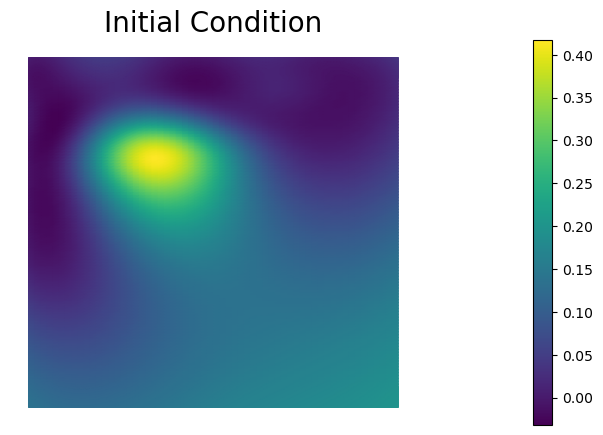

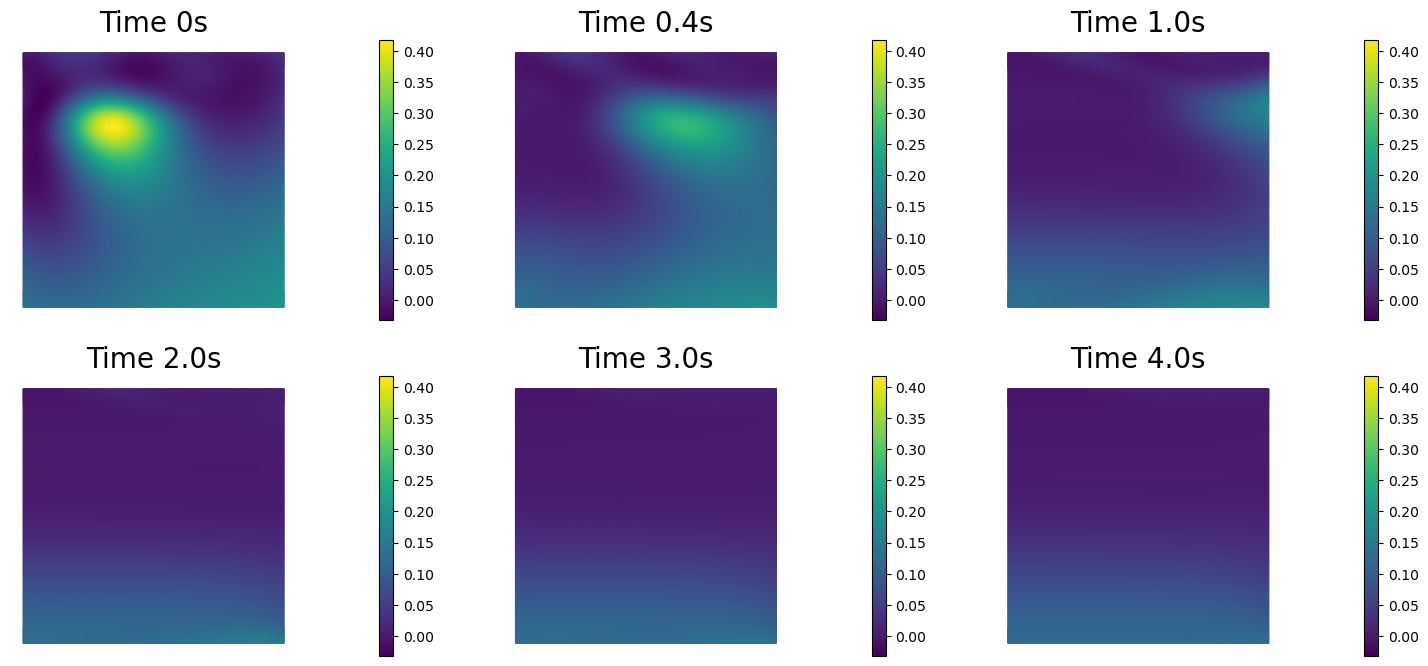

In [27]:
# -------------------------
# Fixed Newton/CG step
# -------------------------

# Use full Hessian
H.misfit_only = False

# Build RHS = -mg robustly (avoid "-mg")
rhs = mg.copy()
rhs *= -1.0

# Solve for increment dm: H dm = -g
solver = CGSolverSteihaug()
solver.set_operator(H)

# IMPORTANT: use SPD preconditioner (guaranteed) to avoid math-domain errors
solver.set_preconditioner(prior.Rsolver)


solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6

dm = problem.generate_vector(PARAMETER)
dm.zero()

solver.solve(dm, rhs)

# Update parameter: m <- m + dm
m.axpy(1.0, dm)

# Forward solve at updated parameter
problem.solveFwd(u, [u, m, p])

# Costs
total_cost, reg_cost, misfit_cost = problem.cost([u, m, p])
print("Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost))

# Store posterior mean safely
posterior.mean = m.copy()

# Robust plot (Vector -> Function)
m_fun = dl.Function(Vh)
m_fun.vector().zero()
m_fun.vector().axpy(1.0, m)

plt.figure(figsize=(7.5, 5))
nb.plot(m_fun, mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")


Posterior trace 0.00344366; Prior trace 0.010428; Correction trace 0.00698436


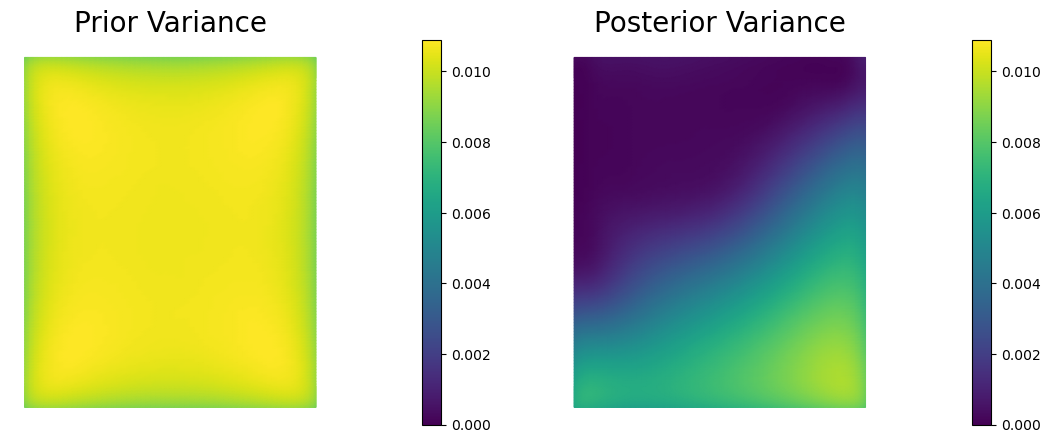

In [28]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=300)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()